In [2]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

## 5. Data Preprocessing

In [3]:
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
num_features = ['age', 'duration', 'campaign', 'pdays', 'previous', 'cons.price.idx', 'cons.conf.idx', 'nr.employed']

#### 5.1 Train - Test split

In [40]:
# data.to_csv('data.csv')

In [4]:
data = pd.read_csv('data.csv')

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('y', axis=1), data.y.values, stratify=data.y, test_size=0.2, random_state=10)

print("Train data shape: ", X_train.shape, y_train.shape)
print("Test data shape: ",X_test.shape, y_test.shape)

Train data shape:  (32592, 19) (32592,)
Test data shape:  (8148, 19) (8148,)


#### 5.2 Data transformation

##### 5.2.1 Numerical features scaling

In [6]:
scaler = StandardScaler()
scaler = scaler.fit(data[num_features])

In [7]:
# creating new empty dataframes to store processed data for training
X_train_processed = X_train.drop(cat_features, axis=1)
X_test_processed = X_test.drop(cat_features, axis=1)
X_train_processed.columns

Index(['Unnamed: 0', 'age', 'duration', 'campaign', 'pdays', 'previous',
       'cons.price.idx', 'cons.conf.idx', 'nr.employed'],
      dtype='object')

In [8]:
X_train_processed.reset_index(drop=True, inplace=True)
X_test_processed.reset_index(drop=True, inplace=True)

In [9]:
# transform all numerical features and save it new dataframes
X_train_processed[num_features] = scaler.transform(X_train[num_features])
X_test_processed[num_features] = scaler.transform(X_test[num_features])

##### 5.2.2 Categorical feature tranformation

* We will tranform categorical features using onehot encoder

In [10]:
onehotencoder = OneHotEncoder(handle_unknown='ignore')
cat_features_ohe = onehotencoder.fit(X_train[cat_features])

In [11]:
X_train_ohe = cat_features_ohe.transform(X_train[cat_features])
X_test_ohe = cat_features_ohe.transform(X_test[cat_features])

In [12]:
X_train_ohe.toarray().shape

(32592, 52)

In [13]:
cat_feature_labels_ohe = np.concatenate(cat_features_ohe.categories_).ravel().tolist()

In [14]:
X_train_ohe = pd.DataFrame(X_train_ohe.toarray(), columns=cat_feature_labels_ohe)
X_test_ohe = pd.DataFrame(X_test_ohe.toarray(), columns=cat_feature_labels_ohe)

In [15]:
print("shape of categorical features of train and test sets after converting categorical features with one hot encoding:")
X_train_ohe.shape, X_test_ohe.shape

shape of categorical features of train and test sets after converting categorical features with one hot encoding:


((32592, 52), (8148, 52))

##### 5.2.3 Merging transformed numerical features and categorical features

In [16]:
X_train_final = pd.concat([X_train_ohe, X_train_processed], axis=1)
X_test_final = pd.concat([X_test_ohe, X_test_processed], axis=1)

print("Final processed train data and test data shapes: ")
print(X_train_final.shape, X_test_final.shape)

Final processed train data and test data shapes: 
(32592, 61) (8148, 61)


In [17]:
X_train_final.drop('Unnamed: 0', axis=1, inplace=True)
X_test_final.drop('Unnamed: 0', axis=1, inplace=True)

In [125]:
# X_train_final.to_csv('X_train_final.csv') #, index=False
# X_test_final.to_csv('X_test_final.csv') #, index=False

## 6. Modeling

In [157]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import confusion_matrix
from scikitplot.metrics import plot_cumulative_gain

In [19]:
def print_confusion_matrix_accuracy(model, X_test, y_true):
    # print confusion matrix
    y_pred = model.predict(X_test)
    confusion_matrix_test = confusion_matrix(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix_test.flatten()
    accuracy = (tp + tn)/ (tn + fp + fn + tp)
    print("Model Accuracy: ", accuracy)
    
    # code reference - https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    confusion_matrix_test.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         confusion_matrix_test.flatten()/np.sum(confusion_matrix_test)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(confusion_matrix_test, annot=labels, fmt='', cmap='Greens')
    plt.title("Confusion Matrix for Test Data")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
        
    return y_pred, accuracy


In [20]:
def plot_auc(model, X_train, X_test, y_train, y_test):
    # AUC
    y_train_pred_prob = model.predict_proba(X_train) # taking only predictions for positive class
    y_test_pred_prob = model.predict_proba(X_test) # taking only predictions for positive class

    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred_prob[:, 1])
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred_prob[:, 1])

    plt.plot(train_fpr, train_tpr, label='Train AUC:'+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label='Test AUC:'+str(auc(test_fpr, test_tpr)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC curve for train and test sets')
    plt.legend()
    plt.show()

    return y_train_pred_prob, y_test_pred_prob, auc(test_fpr, test_tpr)

In [21]:
def precision_recall_f1(y_test, y_pred):
    precision, recall, f1_beta, support = precision_recall_fscore_support(y_test, y_pred) #, average='micro'
    print('Precision Score for class-0:', precision[0], 'and class-1: ', precision[1])
    print('-'*100)
    print('Recall Score for class-0:', recall[0], 'and class-1:', recall[1])
    print('-'*100)
    print('F1 Score for class-0:', f1_beta[0], 'and class-1:', f1_beta[1])
    # print('Support: ', support)
    return precision, recall, f1_beta

In [22]:
def plot_gain_curve(y_true, y_pred_prob, x, y):
    plot_cumulative_gain(y_true, y_pred_prob)
    plt.vlines(x=x, ymax=1, ymin=0, colors='g', linestyles='--')
    plt.hlines(y=y, xmax=0.9, xmin=0, colors='g', linestyles='--')
    plt.show()
    
    # plot_lift_curve(y_test, y_test_pred_prob)

In [112]:
def get_lift_index(y_true, y_pred_prob):
    decile_df = pd.DataFrame(list(zip(y_true, y_pred_prob[:, 1])), columns=['y_true','y_pred'])
    decile_df['decile'] = pd.qcut(decile_df.y_pred, 10, duplicates='drop') #, duplicates='drop'  labels=np.arange(10,0,-1),
    lift_df = decile_df.groupby('decile')['y_pred'].count().reset_index()
    lift_df.rename({'y_pred':'total'}, axis=1, inplace=True)
    lift_df_pred = decile_df[decile_df.y_true==1].groupby('decile')['y_true'].count().reset_index()
    lift_df_final = lift_df.merge(lift_df_pred, on='decile')
    lift_df_final = lift_df_final.sort_values(['decile'], ascending=False)

    lift_df_final['decile'] = [(i+1) for i in range(len(lift_df_final.decile.unique()))]
    
    # calculate the weighted lift index value
    w = 1 # initializing the weight to 1
    lift_index = 0.0
    for cnt in lift_df_final.y_true.values:
        lift_index += cnt * w
        w = w - 0.1
    
    lift_index = lift_index/lift_df_final.y_true.sum()
    return lift_index

In [23]:
metrics = dict()

### 6.1 Logistic Regression

In [47]:
lr = LogisticRegression(random_state=10, max_iter=1000) #, max_iter=500

model = lr.fit(X_train_final, y_train)

##### 6.1.1 Performance Analysis - Confusion matrix, Accuracy, AUC, F1 Score, LIFT

Model Accuracy:  0.9128620520373097


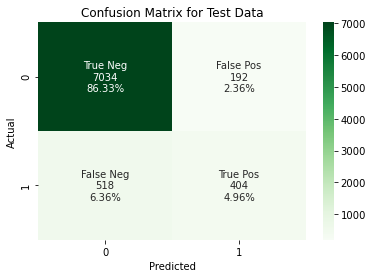

In [48]:
y_test_pred, acc = print_confusion_matrix_accuracy(model, X_test_final, y_test)

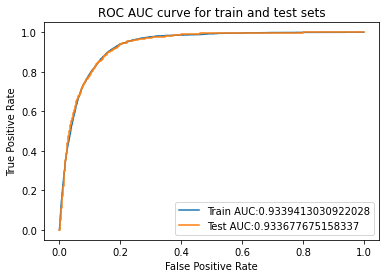

In [49]:
y_train_pred_prob, y_test_pred_prob, roc_auc = plot_auc(model, X_train_final, X_test_final, y_train, y_test)

In [50]:
prec, rec, f1 = precision_recall_f1(y_test, y_test_pred)

Precision Score for class-0: 0.9314088983050848 and class-1:  0.6778523489932886
----------------------------------------------------------------------------------------------------
Recall Score for class-0: 0.9734292831442015 and class-1: 0.43817787418655096
----------------------------------------------------------------------------------------------------
F1 Score for class-0: 0.9519556096900799 and class-1: 0.5322793148880106


In [51]:
lift_index = get_lift_index(y_test, y_test_pred_prob)

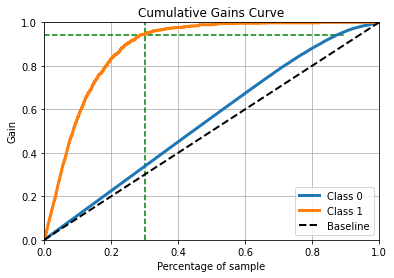

In [52]:
plot_gain_curve(y_test, y_test_pred_prob, 0.3, 0.94)

* From the above cumulative gain curve...
    * Orange curve represents the cumulative gain for positive class.
    * A green horizontal and vertical dashed lines are plotted to denote the point where gain curve begins to platue
    * This intersection point tells us, with only 30% of the leads we can acheive 94% of the conversion rate.

In [53]:
metrics['LR'] = dict()
metrics['LR']['accuracy'] = acc
metrics['LR']['auc'] = roc_auc
metrics['LR']['prec'] = prec
metrics['LR']['recal'] = rec
metrics['LR']['f1'] = f1
metrics['LR']['lift'] = lift_index

##### The below snippet is taken to cross check whether the above cumulative gain plot is giving the same result as this gain curve

In [41]:
# decile_df = pd.DataFrame(list(zip(np.hstack((y_train,y_test)), np.hstack((y_train_pred_prob[:, 1],y_test_pred_prob[:, 1])))), columns=['y_true','y_pred'])
decile_df = pd.DataFrame(list(zip(y_test, y_test_pred_prob[:, 1])), columns=['y_true','y_pred'])

In [110]:
# this piece of code taken from 
# https://medium.com/the-innovation/lead-conversion-score-prediction-using-python-a65d5bb7ccff
# to learn and understand the concept of lift curve analysis


decile_df['decile'] = pd.qcut(decile_df.y_pred, 10) #, labels=np.arange(10,0,-1)

lift_df = decile_df.groupby('decile')['y_pred'].count().reset_index()

lift_df.rename({'y_pred':'total'}, axis=1, inplace=True)

lift_df_pred = decile_df[decile_df.y_true==1].groupby('decile')['y_true'].count().reset_index()

lift_df_final = lift_df.merge(lift_df_pred, on='decile')

lift_df_final = lift_df_final.sort_values(['decile'], ascending=False)

lift_df_final['decile'] = [(i+1) for i in range(len(lift_df_final.decile.unique()))]

lift_df_final['cumresp'] = lift_df_final.y_true.cumsum()

lift_df_final['gain'] = (lift_df_final['cumresp']/sum(lift_df_final['y_true'])) * 100

lift_df_final['cumlift'] = lift_df_final['gain']/(lift_df_final['decile'].astype('int') * (100/10))

In [111]:
lift_df_final

,decile,total,y_true,cumresp,gain,cumlift
9,1,815,519,519,56.290672,5.629067
8,2,815,249,768,83.297180,4.164859
7,3,815,104,872,94.577007,3.152567
6,4,814,28,900,97.613883,2.440347
5,5,815,12,912,98.915401,1.978308
4,6,815,6,918,99.566161,1.659436
3,7,814,2,920,99.783080,1.425473
2,8,815,0,920,99.783080,1.247289
1,9,815,2,922,100.000000,1.111111
0,10,815,0,922,100.000000,1.000000


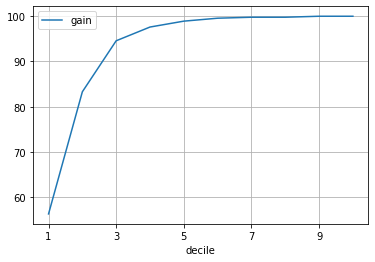

In [93]:
lift_df_final.plot.line(x='decile', y='gain')
plt.grid()
plt.show()

* The above curve also showing the same gain rate as the cumulative curve which was drwan using scikit-plot

### 6.2 Naive Bayes

In [54]:
gnb_clf = GaussianNB()

gnb_clf.fit(X_train_final, y_train)

GaussianNB()

#### 6.2.1 Performance Analysis - Confusion matrix, Accuracy, AUC, F1 Score, LIFT

Model Accuracy:  0.8718703976435935


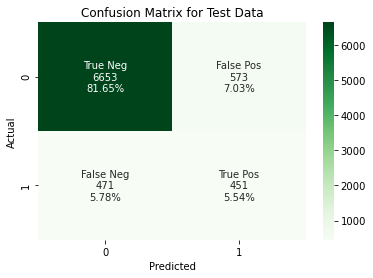

In [55]:
y_test_pred, acc = print_confusion_matrix_accuracy(gnb_clf, X_test_final, y_test)

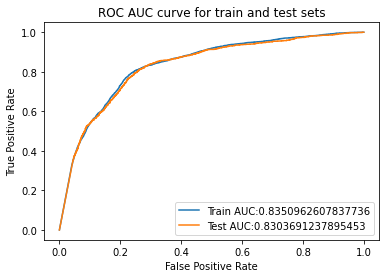

In [56]:
y_train_pred_prob, y_test_pred_prob, roc_auc = plot_auc(gnb_clf, X_train_final, X_test_final, y_train, y_test)

In [57]:
prec, rec, f1 = precision_recall_f1(y_test, y_test_pred)

Precision Score for class-0: 0.9338854576080854 and class-1:  0.4404296875
----------------------------------------------------------------------------------------------------
Recall Score for class-0: 0.9207030168834763 and class-1: 0.4891540130151844
----------------------------------------------------------------------------------------------------
F1 Score for class-0: 0.927247386759582 and class-1: 0.46351490236382326


In [58]:
lift_index = get_lift_index(y_test, y_test_pred_prob)

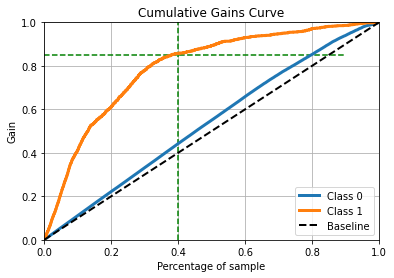

In [59]:
plot_gain_curve(y_test, y_test_pred_prob, x=0.4, y=0.85)

* From the above cumulative gain curve...
    * Orange curve represents the cumulative gain for positive class.
    * A green horizontal and vertical dashed lines are plotted to denote the point where gain curve begins to platue
    * This intersection point tells us, with only 40% of the leads we can acheive 85% of the conversion rate.

In [60]:
metrics['NB'] = dict()
metrics['NB']['accuracy'] = acc
metrics['NB']['auc'] = roc_auc
metrics['NB']['prec'] = prec
metrics['NB']['recal'] = rec
metrics['NB']['f1'] = f1
metrics['NB']['lift'] = lift_index

### 6.3 SVM

#### 6.3.1 SVC with RBF kernel

In [148]:
svc_clf = SVC(probability=True)

svc_clf.fit(X_train_final, y_train)

SVC(probability=True)

##### 6.3.1.1 Performance Analysis - Confusion matrix, Accuracy, AUC, F1 Score, LIFT

Model Accuracy:  0.9117574864997545


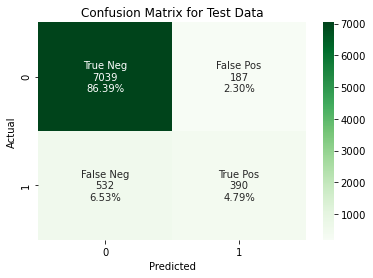

In [149]:
y_test_pred, acc = print_confusion_matrix_accuracy(svc_clf, X_test_final, y_test)

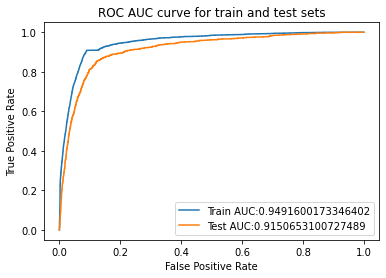

In [150]:
y_train_pred_prob, y_test_pred_prob, roc_auc = plot_auc(svc_clf, X_train_final, X_test_final, y_train, y_test)

In [151]:
prec, rec, f1 = precision_recall_f1(y_test, y_test_pred)

Precision Score for class-0: 0.9297318716153744 and class-1:  0.6759098786828422
----------------------------------------------------------------------------------------------------
Recall Score for class-0: 0.9741212288956546 and class-1: 0.4229934924078091
----------------------------------------------------------------------------------------------------
F1 Score for class-0: 0.9514090694059606 and class-1: 0.5203468979319547


In [152]:
lift_index = get_lift_index(y_test, y_test_pred_prob)

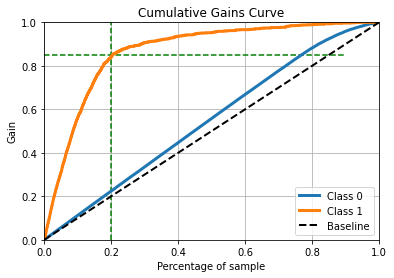

In [154]:
plot_gain_curve(y_test, y_test_pred_prob, x=0.2, y=0.85)

* From the above cumulative gain curve...
    * Orange curve represents the cumulative gain for positive class.
    * A green horizontal and vertical dashed lines are plotted to denote the point where gain curve begins to platue
    * This intersection point tells us, with only 20% of the leads we can acheive 85% of the conversion rate.

In [155]:
metrics['SVC'] = dict()
metrics['SVC']['accuracy'] = acc
metrics['SVC']['auc'] = roc_auc
metrics['SVC']['prec'] = prec
metrics['SVC']['recal'] = rec
metrics['SVC']['f1'] = f1
metrics['SVC']['lift'] = lift_index

#### 6.3.2 SVC - Linear Kernel

In [163]:
svclin_clf = SVC(kernel='linear', probability=True)

svclin_clf.fit(X_train_final, y_train)

SVC(kernel='linear', probability=True)

##### 6.3.2.1 Performance Analysis - Confusion matrix, Accuracy, AUC, F1 Score, LIFT

Model Accuracy:  0.907093765341188


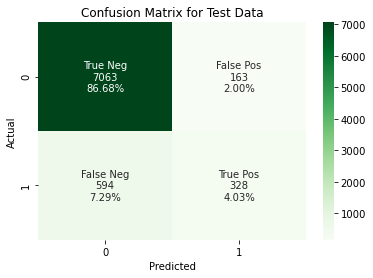

In [164]:
y_test_pred, acc = print_confusion_matrix_accuracy(svclin_clf, X_test_final, y_test)

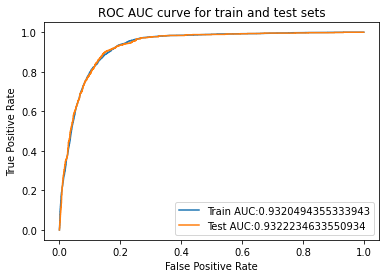

In [165]:
y_train_pred_prob, y_test_pred_prob, roc_auc = plot_auc(svclin_clf, X_train_final, X_test_final, y_train, y_test)

In [166]:
prec, rec, f1 = precision_recall_f1(y_test, y_test_pred)

Precision Score for class-0: 0.9224239258195116 and class-1:  0.6680244399185336
----------------------------------------------------------------------------------------------------
Recall Score for class-0: 0.9774425685026293 and class-1: 0.3557483731019523
----------------------------------------------------------------------------------------------------
F1 Score for class-0: 0.9491365988040046 and class-1: 0.4642604387827318


In [167]:
lift_index = get_lift_index(y_test, y_test_pred_prob)

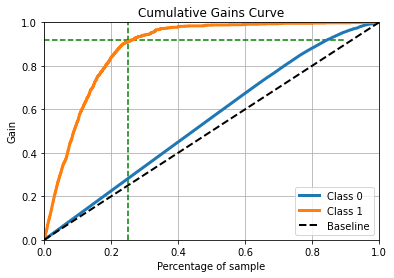

In [169]:
plot_gain_curve(y_test, y_test_pred_prob, x=0.25, y=0.92)

* From the above cumulative gain curve...
    * Orange curve represents the cumulative gain for positive class.
    * A green horizontal and vertical dashed lines are plotted to denote the point where gain curve begins to platue
    * This intersection point tells us, with only 20% of the leads we can acheive 85% of the conversion rate.

In [170]:
metrics['SVC Linear'] = dict()
metrics['SVC Linear']['accuracy'] = acc
metrics['SVC Linear']['auc'] = roc_auc
metrics['SVC Linear']['prec'] = prec
metrics['SVC Linear']['recal'] = rec
metrics['SVC Linear']['f1'] = f1
metrics['SVC Linear']['lift'] = lift_index

#### 6.3.3 SVC - Polynomial Kernel

In [176]:
svcpoly_clf = SVC(kernel='poly', probability=True)

svcpoly_clf.fit(X_train_final, y_train)

SVC(kernel='poly', probability=True)

##### 6.3.1.1 Performance Analysis - Confusion matrix, Accuracy, AUC, F1 Score, LIFT

Model Accuracy:  0.9095483554246441


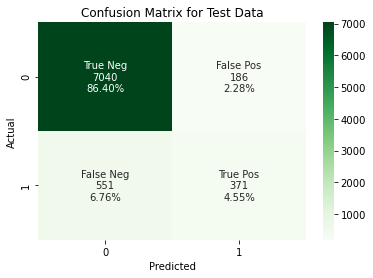

In [177]:
y_test_pred, acc = print_confusion_matrix_accuracy(svcpoly_clf, X_test_final, y_test)

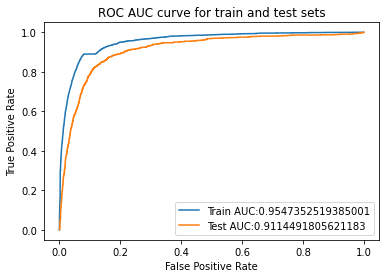

In [178]:
y_train_pred_prob, y_test_pred_prob, roc_auc = plot_auc(svcpoly_clf, X_train_final, X_test_final, y_train, y_test)

In [179]:
prec, rec, f1 = precision_recall_f1(y_test, y_test_pred)

Precision Score for class-0: 0.9274140429455935 and class-1:  0.6660682226211849
----------------------------------------------------------------------------------------------------
Recall Score for class-0: 0.9742596180459452 and class-1: 0.40238611713665945
----------------------------------------------------------------------------------------------------
F1 Score for class-0: 0.9502598366740906 and class-1: 0.5016903313049358


In [180]:
lift_index = get_lift_index(y_test, y_test_pred_prob)

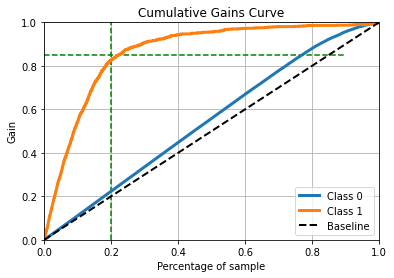

In [181]:
plot_gain_curve(y_test, y_test_pred_prob, x=0.2, y=0.85)

* From the above cumulative gain curve...
    * Orange curve represents the cumulative gain for positive class.
    * A green horizontal and vertical dashed lines are plotted to denote the point where gain curve begins to platue
    * This intersection point tells us, with only 20% of the leads we can acheive 85% of the conversion rate.

In [182]:
metrics['SVC Poly'] = dict()
metrics['SVC Poly']['accuracy'] = acc
metrics['SVC Poly']['auc'] = roc_auc
metrics['SVC Poly']['prec'] = prec
metrics['SVC Poly']['recal'] = rec
metrics['SVC Poly']['f1'] = f1
metrics['SVC Poly']['lift'] = lift_index

### 6.4 Decision Tree Classifier

In [68]:
dt_clf = DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=10)

dt_clf.fit(X_train_final, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=10)

##### 6.4.1 Performance Analysis - Confusion matrix, Accuracy, AUC, F1 Score, LIFT

Model Accuracy:  0.9085665193912617


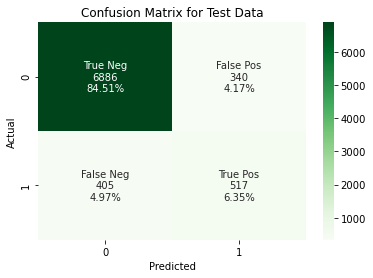

In [69]:
y_test_pred, acc = print_confusion_matrix_accuracy(dt_clf, X_test_final, y_test)

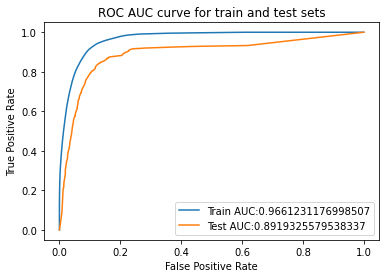

In [70]:
y_train_pred_prob, y_test_pred_prob, roc_auc = plot_auc(dt_clf, X_train_final, X_test_final, y_train, y_test)

In [71]:
prec, rec, f1 = precision_recall_f1(y_test, y_test_pred)

Precision Score for class-0: 0.9444520641887258 and class-1:  0.603267211201867
----------------------------------------------------------------------------------------------------
Recall Score for class-0: 0.9529476889011902 and class-1: 0.5607375271149675
----------------------------------------------------------------------------------------------------
F1 Score for class-0: 0.9486808569263623 and class-1: 0.5812254075323214


In [113]:
lift_index = get_lift_index(y_test, y_test_pred_prob)

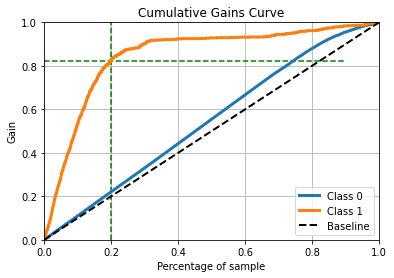

In [115]:
plot_gain_curve(y_test, y_test_pred_prob, x=0.2, y=0.82)

* From the above cumulative gain curve...
    * Orange curve represents the cumulative gain for positive class.
    * A green horizontal and vertical dashed lines are plotted to denote the point where gain curve begins to platue
    * This intersection point tells us, with only 20% of the leads we can acheive 82% of the conversion rate.

In [116]:
metrics['DT'] = dict()
metrics['DT']['accuracy'] = acc
metrics['DT']['auc'] = roc_auc
metrics['DT']['prec'] = prec
metrics['DT']['recal'] = rec
metrics['DT']['f1'] = f1
metrics['DT']['lift'] = lift_index

#### 6.5 Random Forest Classifier

In [117]:
rf_clf = RandomForestClassifier(min_samples_leaf=2, random_state=10) #n_estimators=500, max_depth=10, min_samples_split=5

rf_clf.fit(X_train_final, y_train)

RandomForestClassifier(min_samples_leaf=2, random_state=10)

##### 6.5.1 Performance Analysis - Confusion matrix, Accuracy, AUC, F1 Score, LIFT

Model Accuracy:  0.9134756995581738


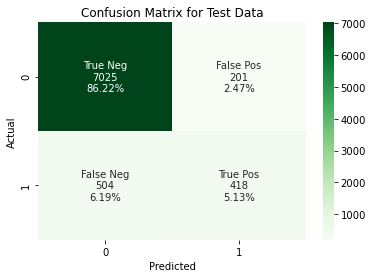

In [119]:
y_test_pred, acc = print_confusion_matrix_accuracy(rf_clf, X_test_final, y_test)

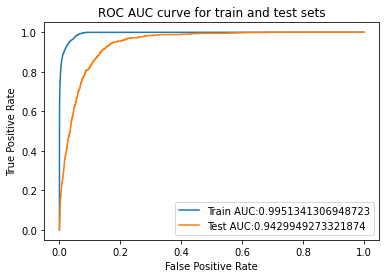

In [120]:
y_train_pred_prob, y_test_pred_prob, roc_auc = plot_auc(rf_clf, X_train_final, X_test_final, y_train, y_test)

In [121]:
prec, rec, f1 = precision_recall_f1(y_test, y_test_pred)

Precision Score for class-0: 0.9330588391552663 and class-1:  0.6752827140549273
----------------------------------------------------------------------------------------------------
Recall Score for class-0: 0.972183780791586 and class-1: 0.45336225596529284
----------------------------------------------------------------------------------------------------
F1 Score for class-0: 0.95221958658082 and class-1: 0.5425048669695003


In [122]:
lift_index = get_lift_index(y_test, y_test_pred_prob)
lift_index

0.9357917570498915

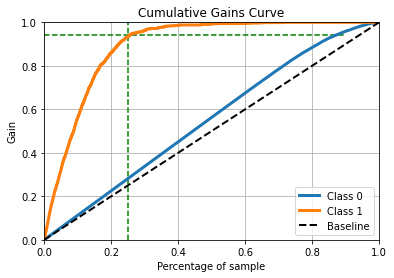

In [124]:
plot_gain_curve(y_test, y_test_pred_prob, x=0.25, y=0.94)

* From the above cumulative gain curve...
    * Orange curve represents the cumulative gain for positive class.
    * A green horizontal and vertical dashed lines are plotted to denote the point where gain curve begins to platue
    * This intersection point tells us, with only 25% of the leads we can acheive 94% of the conversion rate.

In [123]:
metrics['RF'] = dict()
metrics['RF']['accuracy'] = acc
metrics['RF']['auc'] = roc_auc
metrics['RF']['prec'] = prec
metrics['RF']['recal'] = rec
metrics['RF']['f1'] = f1
metrics['RF']['lift'] = lift_index

#### 6.6 XGBoost Classifier

In [125]:
xgb_clf = XGBClassifier(random_state=10)

xgb_clf.fit(X_train_final, y_train)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:19:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

##### 6.6.1 Performance Analysis - Confusion matrix, Accuracy, AUC, F1 Score, LIFT

Model Accuracy:  0.9138438880706922


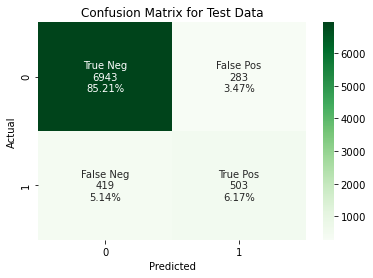

In [126]:
y_test_pred, acc = print_confusion_matrix_accuracy(xgb_clf, X_test_final, y_test)

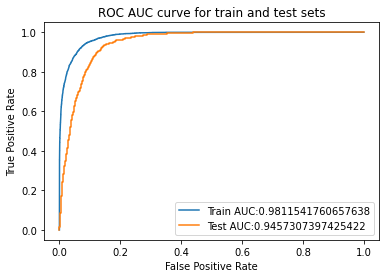

In [127]:
y_train_pred_prob, y_test_pred_prob, roc_auc = plot_auc(xgb_clf, X_train_final, X_test_final, y_train, y_test)

In [128]:
prec, rec, f1 = precision_recall_f1(y_test, y_test_pred)

Precision Score for class-0: 0.9430861179027438 and class-1:  0.6399491094147582
----------------------------------------------------------------------------------------------------
Recall Score for class-0: 0.9608358704677553 and class-1: 0.5455531453362256
----------------------------------------------------------------------------------------------------
F1 Score for class-0: 0.9518782561009048 and class-1: 0.5889929742388758


In [129]:
lift_index = get_lift_index(y_test, y_test_pred_prob)
lift_index

0.9400216919739696

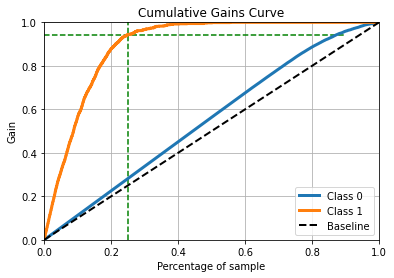

In [130]:
plot_gain_curve(y_test, y_test_pred_prob, x=0.25, y=0.94)

* From the above cumulative gain curve...
    * Orange curve represents the cumulative gain for positive class.
    * A green horizontal and vertical dashed lines are plotted to denote the point where gain curve begins to platue
    * This intersection point tells us, with only 25% of the leads we can acheive 94% of the conversion rate.

In [131]:
metrics['XGB'] = dict()
metrics['XGB']['accuracy'] = acc
metrics['XGB']['auc'] = roc_auc
metrics['XGB']['prec'] = prec
metrics['XGB']['recal'] = rec
metrics['XGB']['f1'] = f1
metrics['XGB']['lift'] = lift_index

#### 6.7 CatBoost Classifier

In [132]:
cat_clf = CatBoostClassifier()

cat_clf.fit(X_train_final, y_train)

Learning rate set to 0.045607
0:	learn: 0.6232843	total: 66.7ms	remaining: 1m 6s
1:	learn: 0.5659036	total: 75.5ms	remaining: 37.7s
2:	learn: 0.5228380	total: 86.7ms	remaining: 28.8s
3:	learn: 0.4789803	total: 96.3ms	remaining: 24s
4:	learn: 0.4365238	total: 105ms	remaining: 20.9s
5:	learn: 0.4056413	total: 114ms	remaining: 18.8s
6:	learn: 0.3800534	total: 122ms	remaining: 17.3s
7:	learn: 0.3516876	total: 132ms	remaining: 16.4s
8:	learn: 0.3285616	total: 142ms	remaining: 15.6s
9:	learn: 0.3158390	total: 151ms	remaining: 14.9s
10:	learn: 0.3023456	total: 161ms	remaining: 14.4s
11:	learn: 0.2919162	total: 171ms	remaining: 14.1s
12:	learn: 0.2802945	total: 181ms	remaining: 13.8s
13:	learn: 0.2718895	total: 191ms	remaining: 13.4s
14:	learn: 0.2635672	total: 203ms	remaining: 13.3s
15:	learn: 0.2553610	total: 213ms	remaining: 13.1s
16:	learn: 0.2472698	total: 222ms	remaining: 12.9s
17:	learn: 0.2430353	total: 232ms	remaining: 12.7s
18:	learn: 0.2364641	total: 242ms	remaining: 12.5s
19:	learn

167:	learn: 0.1692859	total: 1.62s	remaining: 8.01s
168:	learn: 0.1691913	total: 1.63s	remaining: 8s
169:	learn: 0.1690918	total: 1.63s	remaining: 7.98s
170:	learn: 0.1689920	total: 1.64s	remaining: 7.96s
171:	learn: 0.1688795	total: 1.65s	remaining: 7.95s
172:	learn: 0.1687553	total: 1.66s	remaining: 7.94s
173:	learn: 0.1686714	total: 1.67s	remaining: 7.93s
174:	learn: 0.1686144	total: 1.68s	remaining: 7.92s
175:	learn: 0.1685509	total: 1.69s	remaining: 7.91s
176:	learn: 0.1684847	total: 1.7s	remaining: 7.89s
177:	learn: 0.1684029	total: 1.71s	remaining: 7.89s
178:	learn: 0.1683610	total: 1.72s	remaining: 7.87s
179:	learn: 0.1683059	total: 1.73s	remaining: 7.86s
180:	learn: 0.1681422	total: 1.74s	remaining: 7.86s
181:	learn: 0.1680773	total: 1.75s	remaining: 7.85s
182:	learn: 0.1679885	total: 1.76s	remaining: 7.84s
183:	learn: 0.1679349	total: 1.77s	remaining: 7.83s
184:	learn: 0.1678656	total: 1.77s	remaining: 7.82s
185:	learn: 0.1678037	total: 1.79s	remaining: 7.83s
186:	learn: 0.16

341:	learn: 0.1573614	total: 3.24s	remaining: 6.24s
342:	learn: 0.1572828	total: 3.25s	remaining: 6.23s
343:	learn: 0.1572086	total: 3.26s	remaining: 6.22s
344:	learn: 0.1571443	total: 3.27s	remaining: 6.21s
345:	learn: 0.1570919	total: 3.28s	remaining: 6.2s
346:	learn: 0.1570349	total: 3.29s	remaining: 6.19s
347:	learn: 0.1569617	total: 3.3s	remaining: 6.18s
348:	learn: 0.1569084	total: 3.31s	remaining: 6.17s
349:	learn: 0.1568369	total: 3.32s	remaining: 6.17s
350:	learn: 0.1567557	total: 3.33s	remaining: 6.16s
351:	learn: 0.1567052	total: 3.34s	remaining: 6.15s
352:	learn: 0.1566466	total: 3.35s	remaining: 6.14s
353:	learn: 0.1565757	total: 3.36s	remaining: 6.13s
354:	learn: 0.1565267	total: 3.37s	remaining: 6.12s
355:	learn: 0.1564347	total: 3.38s	remaining: 6.11s
356:	learn: 0.1564098	total: 3.39s	remaining: 6.1s
357:	learn: 0.1563407	total: 3.4s	remaining: 6.09s
358:	learn: 0.1562868	total: 3.4s	remaining: 6.08s
359:	learn: 0.1562285	total: 3.41s	remaining: 6.07s
360:	learn: 0.156

512:	learn: 0.1478637	total: 4.86s	remaining: 4.61s
513:	learn: 0.1478015	total: 4.87s	remaining: 4.6s
514:	learn: 0.1477303	total: 4.88s	remaining: 4.59s
515:	learn: 0.1476882	total: 4.89s	remaining: 4.58s
516:	learn: 0.1476207	total: 4.89s	remaining: 4.57s
517:	learn: 0.1475680	total: 4.9s	remaining: 4.56s
518:	learn: 0.1474977	total: 4.91s	remaining: 4.55s
519:	learn: 0.1474441	total: 4.92s	remaining: 4.54s
520:	learn: 0.1474029	total: 4.93s	remaining: 4.53s
521:	learn: 0.1473458	total: 4.94s	remaining: 4.52s
522:	learn: 0.1472864	total: 4.95s	remaining: 4.51s
523:	learn: 0.1472678	total: 4.96s	remaining: 4.5s
524:	learn: 0.1472135	total: 4.97s	remaining: 4.49s
525:	learn: 0.1471852	total: 4.97s	remaining: 4.48s
526:	learn: 0.1471267	total: 4.99s	remaining: 4.47s
527:	learn: 0.1470644	total: 4.99s	remaining: 4.46s
528:	learn: 0.1470319	total: 5s	remaining: 4.45s
529:	learn: 0.1469829	total: 5.01s	remaining: 4.44s
530:	learn: 0.1468880	total: 5.02s	remaining: 4.43s
531:	learn: 0.1468

684:	learn: 0.1400479	total: 6.48s	remaining: 2.98s
685:	learn: 0.1400135	total: 6.49s	remaining: 2.97s
686:	learn: 0.1399551	total: 6.5s	remaining: 2.96s
687:	learn: 0.1399092	total: 6.5s	remaining: 2.95s
688:	learn: 0.1398573	total: 6.51s	remaining: 2.94s
689:	learn: 0.1398223	total: 6.52s	remaining: 2.93s
690:	learn: 0.1397619	total: 6.53s	remaining: 2.92s
691:	learn: 0.1397247	total: 6.54s	remaining: 2.91s
692:	learn: 0.1396555	total: 6.55s	remaining: 2.9s
693:	learn: 0.1395945	total: 6.56s	remaining: 2.89s
694:	learn: 0.1395588	total: 6.57s	remaining: 2.88s
695:	learn: 0.1395047	total: 6.58s	remaining: 2.87s
696:	learn: 0.1394655	total: 6.59s	remaining: 2.87s
697:	learn: 0.1394581	total: 6.6s	remaining: 2.85s
698:	learn: 0.1394281	total: 6.61s	remaining: 2.85s
699:	learn: 0.1394025	total: 6.62s	remaining: 2.83s
700:	learn: 0.1393487	total: 6.63s	remaining: 2.83s
701:	learn: 0.1393099	total: 6.64s	remaining: 2.82s
702:	learn: 0.1392391	total: 6.65s	remaining: 2.81s
703:	learn: 0.13

860:	learn: 0.1328153	total: 8.11s	remaining: 1.31s
861:	learn: 0.1327585	total: 8.12s	remaining: 1.3s
862:	learn: 0.1327189	total: 8.13s	remaining: 1.29s
863:	learn: 0.1326765	total: 8.14s	remaining: 1.28s
864:	learn: 0.1326554	total: 8.15s	remaining: 1.27s
865:	learn: 0.1326014	total: 8.16s	remaining: 1.26s
866:	learn: 0.1325682	total: 8.17s	remaining: 1.25s
867:	learn: 0.1325122	total: 8.18s	remaining: 1.24s
868:	learn: 0.1324725	total: 8.19s	remaining: 1.23s
869:	learn: 0.1324114	total: 8.19s	remaining: 1.22s
870:	learn: 0.1323678	total: 8.2s	remaining: 1.22s
871:	learn: 0.1323351	total: 8.21s	remaining: 1.21s
872:	learn: 0.1322789	total: 8.22s	remaining: 1.2s
873:	learn: 0.1322398	total: 8.23s	remaining: 1.19s
874:	learn: 0.1321950	total: 8.24s	remaining: 1.18s
875:	learn: 0.1321672	total: 8.25s	remaining: 1.17s
876:	learn: 0.1321330	total: 8.26s	remaining: 1.16s
877:	learn: 0.1321046	total: 8.27s	remaining: 1.15s
878:	learn: 0.1320798	total: 8.28s	remaining: 1.14s
879:	learn: 0.1

##### 6.7.1 Performance Analysis - Confusion matrix, Accuracy, AUC, F1 Score, LIFT

Model Accuracy:  0.9144575355915562


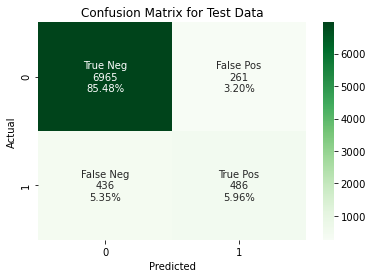

In [133]:
y_test_pred, acc = print_confusion_matrix_accuracy(cat_clf, X_test_final, y_test)

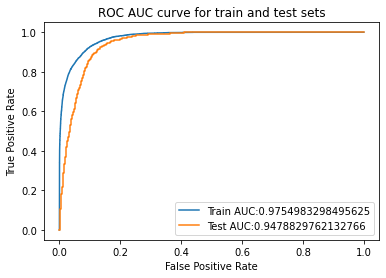

In [134]:
y_train_pred_prob, y_test_pred_prob, roc_auc = plot_auc(cat_clf, X_train_final, X_test_final, y_train, y_test)

In [135]:
prec, rec, f1 = precision_recall_f1(y_test, y_test_pred)

Precision Score for class-0: 0.9410890420213485 and class-1:  0.6506024096385542
----------------------------------------------------------------------------------------------------
Recall Score for class-0: 0.963880431774149 and class-1: 0.527114967462039
----------------------------------------------------------------------------------------------------
F1 Score for class-0: 0.9523483968004376 and class-1: 0.5823846614739364


In [136]:
lift_index = get_lift_index(y_test, y_test_pred_prob)
lift_index

0.9417570498915402

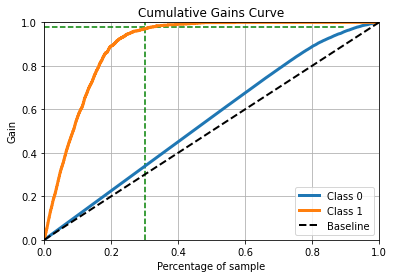

In [137]:
plot_gain_curve(y_test, y_test_pred_prob, x=0.30, y=0.98)

* From the above cumulative gain curve...
    * Orange curve represents the cumulative gain for positive class.
    * A green horizontal and vertical dashed lines are plotted to denote the point where gain curve begins to platue
    * This intersection point tells us, with only 30% of the leads we can acheive 98% of the conversion rate.

In [138]:
metrics['CAT'] = dict()
metrics['CAT']['accuracy'] = acc
metrics['CAT']['auc'] = roc_auc
metrics['CAT']['prec'] = prec
metrics['CAT']['recal'] = rec
metrics['CAT']['f1'] = f1
metrics['CAT']['lift'] = lift_index

#### 6.8 LGBM Classifier

In [139]:
lgbm_clf = LGBMClassifier()

lgbm_clf.fit(X_train_final, y_train)

LGBMClassifier()

##### 6.8.1 Performance Analysis - Confusion matrix, Accuracy, AUC, F1 Score, LIFT

Model Accuracy:  0.9167893961708394


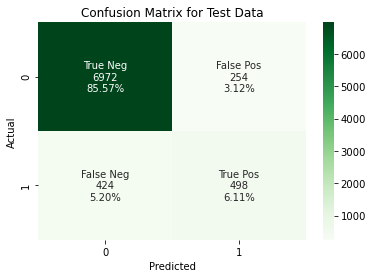

In [140]:
y_test_pred, acc = print_confusion_matrix_accuracy(lgbm_clf, X_test_final, y_test)

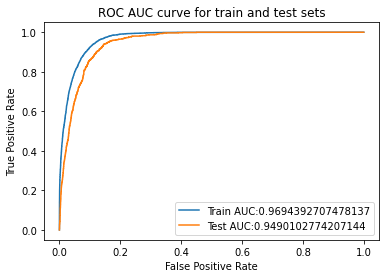

In [141]:
y_train_pred_prob, y_test_pred_prob, roc_auc = plot_auc(lgbm_clf, X_train_final, X_test_final, y_train, y_test)

In [142]:
prec, rec, f1 = precision_recall_f1(y_test, y_test_pred)

Precision Score for class-0: 0.942671714440238 and class-1:  0.6622340425531915
----------------------------------------------------------------------------------------------------
Recall Score for class-0: 0.9648491558261832 and class-1: 0.5401301518438177
----------------------------------------------------------------------------------------------------
F1 Score for class-0: 0.9536315141567502 and class-1: 0.5949820788530465


In [143]:
lift_index = get_lift_index(y_test, y_test_pred_prob)
lift_index

0.941648590021692

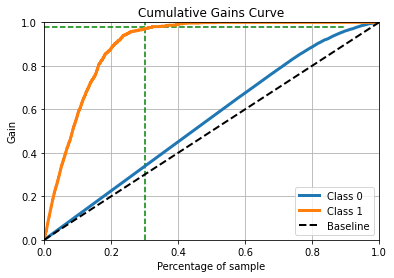

In [144]:
plot_gain_curve(y_test, y_test_pred_prob, x=0.30, y=0.98)

* From the above cumulative gain curve...
    * Orange curve represents the cumulative gain for positive class.
    * A green horizontal and vertical dashed lines are plotted to denote the point where gain curve begins to platue
    * This intersection point tells us, with only 30% of the leads we can acheive 98% of the conversion rate.

In [145]:
metrics['LGBM'] = dict()
metrics['LGBM']['accuracy'] = acc
metrics['LGBM']['auc'] = roc_auc
metrics['LGBM']['prec'] = prec
metrics['LGBM']['recal'] = rec
metrics['LGBM']['f1'] = f1
metrics['LGBM']['lift'] = lift_index

## 7. Summary

In [183]:
from tabulate import tabulate
heads = ['Classifier', 'Accuracy', 'AUC', 'Precision', 'Recall', 'F1_Score', 'Lift Index']

data_table = []
for clf in metrics:
    # print(clf, "====", metric, "====", metrics[clf][metric])
    data_table.append([clf, metrics[clf]['accuracy'], metrics[clf]['auc'], metrics[clf]['prec'][1], 
                       metrics[clf]['recal'][1], metrics[clf]['f1'][1], metrics[clf]['lift']])

print(tabulate(data_table, heads, tablefmt='orgtbl'))

| Classifier   |   Accuracy |      AUC |   Precision |   Recall |   F1_Score |   Lift Index |
|--------------+------------+----------+-------------+----------+------------+--------------|
| LR           |   0.912862 | 0.933678 |    0.677852 | 0.438178 |   0.532279 |     0.929826 |
| NB           |   0.87187  | 0.830369 |    0.44043  | 0.489154 |   0.463515 |     0.838612 |
| SVC          |   0.911757 | 0.915065 |    0.67591  | 0.422993 |   0.520347 |     0.912473 |
| DT           |   0.908567 | 0.891933 |    0.603267 | 0.560738 |   0.581225 |     0.909002 |
| RF           |   0.913476 | 0.942995 |    0.675283 | 0.453362 |   0.542505 |     0.935792 |
| XGB          |   0.913844 | 0.945731 |    0.639949 | 0.545553 |   0.588993 |     0.940022 |
| CAT          |   0.914458 | 0.947883 |    0.650602 | 0.527115 |   0.582385 |     0.941757 |
| LGBM         |   0.916789 | 0.94901  |    0.662234 | 0.54013  |   0.594982 |     0.941649 |
| SVC Linear   |   0.907094 | 0.932223 |    0.668024 | 0.355

* Accuracy, AUC, F1 score and Lift index are at their best for LGBM classifier.
* Precision has best value in LR
* Recall has best value in DT

* Above is the performance of basic classifiers without any hyper parameter tuning. 